In [1]:
import torch
import torchvision.transforms.v2 as v2

In [2]:
from datasets import load_dataset

ds = load_dataset("zh-plus/tiny-imagenet")

In [3]:
class MyDataset():
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, idx):
        x = self.dataset[idx]['image']
        y = self.dataset[idx]['label']
        if self.transform:
            x = self.transform(x)
        
        return x, y

    def __len__(self):
        return len(self.dataset)

In [4]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

data_transforms = {
    'train': v2.Compose([
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ]),
    'val': v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ]),
    'test': v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ])
}

In [5]:
from torch.utils.data import DataLoader

In [6]:
train_dataset = MyDataset(ds['train'], transform=data_transforms['train'])

train_subset, val_subset = torch.utils.data.random_split(train_dataset, [90000, 10000], generator=torch.Generator().manual_seed(1))

test_dataset = MyDataset(ds['valid'], transform=data_transforms['test'])

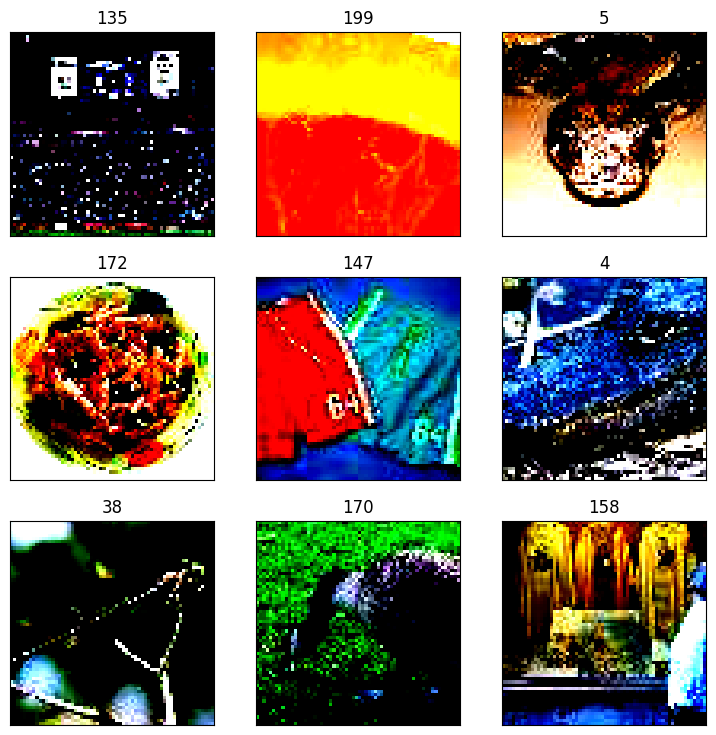

In [7]:
# visualize portion of training data:
import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(9,9))

for i in range(9):
    idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]
    ax = plt.subplot(3, 3, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(label)

    ax.imshow(torch.clamp(img.view(3, 64, 64).permute(1, 2, 0), 0, 1))

In [8]:
BATCH_SIZE = 64
train_data_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Embedding class

class ImageEmbedding(nn.Module):
    """
        take square image of CxNxN pixels and create linear map of PxP patches to embedding dimension D
        Input: (B, C, N, N)
        Output: (B, C * P**2, D)
    """
    def __init__(self, img_size, patch_size, emb_size, num_channels, layer_norm_eps=1e-12, dropout=0.1):
        super().__init__()
        
        if img_size % patch_size != 0:
            raise Exception("image size must be divisible by patch size")
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_channels = num_channels

        max_seq_len = int(num_channels * patch_size**2)

        self.patch_embeddings = nn.Linear(max_seq_len, emb_size, bias=False)
        self.prepend_embedding = nn.Parameter(torch.randn(1, emb_size))
        self.positional_embeddings = nn.Linear(max_seq_len, emb_size, bias=False)

        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("position_ids", torch.arange(max_seq_len).expand((1, -1)).float())

    def forward(self, img):
        # patch input image (C, N, N) --> ((N/P)**2, P**2 * C)
        p = self.patch_size
        img = img.unfold(2, p, p).unfold(3, p, p).transpose(1, 3).reshape(-1, int(self.img_size/self.patch_size)**2, self.patch_size**2 * self.num_channels)
        emb = self.patch_embeddings(img)
        
        # prepend learnable embedding
        batch_size = img.shape[0]  
        prepend_embedding = self.prepend_embedding.expand(batch_size, -1)
        emb = torch.cat((prepend_embedding.unsqueeze(1), emb), dim=1)

        # add positional embedding
        emb = emb + self.positional_embeddings(self.position_ids)

        # add normalization and dropout
        emb = self.ln(emb)
        emb = self.dropout(emb)
        
        return emb

In [11]:
# Implement transformer encoder

class AttentionBlock(nn.Module):
    def __init__(self, emb_size, head_size, mask=False):
        super().__init__()
        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)
        if mask:
            self.att_mask = torch.ones(head_size, head_size)
            self.att_mask = torch.tril(self.att_mask)
            self.att_mask = self.att_mask / torch.sum(self.att_mask, dim=1, keepdim=True)
        else:
            self.att_mask = None
    
    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        att = q @ k.transpose(1, 2) * C**-0.5
        if self.att_mask:
            att *= self.att_mask

        out = F.softmax(att, dim=-1) @ v
        return out


In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, emb_size, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(AttentionBlock(emb_size, head_size) for _ in range(n_heads))
        self.proj = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        return out

In [13]:
class FeedForward(nn.Module):
    def __init__(self, emb_size, scale):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_size, scale * emb_size),
            nn.GELU(),
            nn.Linear(scale * emb_size, emb_size)
        )
    
    def forward(self, x):
        out = self.layers(x)
        return out

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_size, n_heads, scale=4, layer_norm_eps=1e-12):
        super().__init__()
        head_size = emb_size // n_heads

        self.att = MultiHeadedAttention(emb_size, n_heads, head_size)
        self.ff = FeedForward(emb_size, scale)
        self.ln1 = nn.LayerNorm(emb_size, layer_norm_eps)
        self.ln2 = nn.LayerNorm(emb_size, layer_norm_eps)
    
    def forward(self, x):
        out = self.att(self.ln1(x)) + x
        out = self.ff(self.ln2(out)) + out
        return out

In [15]:
class CustomViT(nn.Module):
    def __init__(self, vocab_size, emb_size, img_size, patch_size, num_channels, n_heads, n_layers, scale):
        super().__init__()
        self.emb = ImageEmbedding(img_size, patch_size, emb_size, num_channels)
        
        modules = []
        for _ in range(n_layers):
            modules.append(TransformerBlock(emb_size, n_heads, scale))
        self.blocks = nn.Sequential(*modules)
        self.mlp_head = nn.Linear(emb_size, vocab_size)
    
    def forward(self, x, target=None):
        B, C, N, _ = x.shape

        emb = self.emb(x) # B, T, D
        out = self.blocks(emb) # B, T, D
        all_logits = self.mlp_head(out) # B, T, vocab_size

        # using class token for predictions
        logits = all_logits[:, 0, :]
    
        if not target:
            loss = None
        else:
            loss = F.cross_entropy(logits, target)
        
        return logits, loss

In [16]:
from tqdm import tqdm

In [88]:
# training loop

def train(model, optimizer, criterion, device, num_epochs):
    model.to(device)
    best_acc = 0
    flag = False
        
    for epoch in range(num_epochs):
        model.train()
        with tqdm(total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for data, labels in train_data_loader:
                # move data to mps/cuda
                data = data.to(device)
                labels = labels.to(device)
                # forward pass
                optimizer.zero_grad()

                with torch.autocast(device_type="cuda"):
                    pred = model(data)[0]
                    loss = criterion(pred, labels)
                
                # backwards pass
                loss.backward()
                optimizer.step()
                # update progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())
                break

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_data_loader, criterion, device)

        if best_acc > accuracy:
            if flag:
                print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')
                break
            else:
                flag = True
        else:
            best_acc = accuracy
            flag = False
        print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

In [89]:
def evaluate(model, test_loader, criterion, device):
    model.eval()

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)[0]
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

In [90]:
def predict(model, test_dataloader):
    out = []
    for i in test_dataloader:
        pic = i[0]
        lab = torch.argmax(model(pic))
        out.append(lab.item())
    return out


In [103]:
# from tinyimagenet
NUM_CLASSES = 200 
IMG_SIZE = 64
NUM_CHANNELS = 3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
NUM_EPOCHS = 8
EMB_SIZE = 384
PATCH_SIZE = 2
N_HEADS = 6
N_LAYERS = 6
SCALE = 2
LR = 3e-4

# Default loss: 5.29


In [104]:
model = CustomViT(NUM_CLASSES, EMB_SIZE, IMG_SIZE, PATCH_SIZE, NUM_CHANNELS, N_HEADS, N_LAYERS, SCALE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [7]:
train(model, optimizer, criterion, DEVICE, NUM_EPOCHS)

NameError: name 'train' is not defined

In [63]:
from torchsummary import summary

In [67]:
model = CustomViT(NUM_CLASSES, EMB_SIZE, IMG_SIZE, PATCH_SIZE, NUM_CHANNELS, N_HEADS, N_LAYERS, SCALE)
model.to('cuda')

CustomViT(
  (emb): ImageEmbedding(
    (patch_embeddings): Linear(in_features=12, out_features=32, bias=False)
    (positional_embeddings): Linear(in_features=12, out_features=32, bias=False)
    (ln): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadedAttention(
        (heads): ModuleList(
          (0-7): 8 x AttentionBlock(
            (query): Linear(in_features=32, out_features=4, bias=False)
            (key): Linear(in_features=32, out_features=4, bias=False)
            (value): Linear(in_features=32, out_features=4, bias=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=32, bias=True)
     

In [68]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1024, 32]             384
            Linear-2                   [-1, 32]             384
         LayerNorm-3             [-1, 1025, 32]              64
           Dropout-4             [-1, 1025, 32]               0
    ImageEmbedding-5             [-1, 1025, 32]               0
         LayerNorm-6             [-1, 1025, 32]              64
            Linear-7              [-1, 1025, 4]             128
            Linear-8              [-1, 1025, 4]             128
            Linear-9              [-1, 1025, 4]             128
   AttentionBlock-10              [-1, 1025, 4]               0
           Linear-11              [-1, 1025, 4]             128
           Linear-12              [-1, 1025, 4]             128
           Linear-13              [-1, 1025, 4]             128
   AttentionBlock-14              [-1, 

Try accelerating training by 
- splitting across GPU's
- mixed precision operations
    - https://developer.nvidia.com/automatic-mixed-precision
- workers for data loading
